# Gradient Boosting Classifier

ToDo's:
- Renaming of variables
- Nice print statements
- Hypertuning for CNN model
- Change multilabel classification (optional)

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from sklearn.preprocessing import *
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import tf2onnx
from onnx import *
from onnx_tf.backend import prepare
import pickle
import sys
import joblib
import os
import keras_tuner as kt

IMAGE_SIZE = [32, 32]

In [2]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [3]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


## Binary Classification

### Data Preparation

In [4]:
# convert labels to binary
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [5]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)


print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [6]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)


### Feature Generation Model

In [7]:
# Simple CNN model

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(x) # 32x32 -> 16x16
y = tf.keras.layers.Conv2D(kernel_size=3, filters=16, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 16x16 -> 8x8
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 8x8 -> 4x4
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)


model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080  

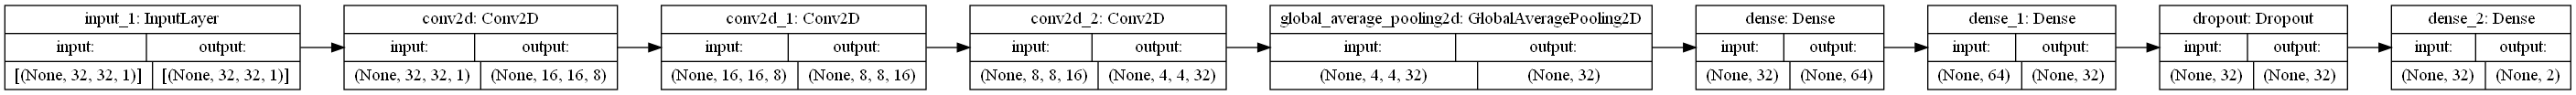

In [8]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/20
12/12 [==============================] - 3s 56ms/step - loss: 0.7298 - accuracy: 0.5611 - val_loss: 0.7172 - val_accuracy: 0.6000
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 0.7214 - accuracy: 0.5167 - val_loss: 0.6974 - val_accuracy: 0.4000
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 0.6599 - accuracy: 0.6167 - val_loss: 0.6808 - val_accuracy: 0.6000
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 0.6630 - accuracy: 0.6278 - val_loss: 0.6869 - val_accuracy: 0.6000
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 0.6739 - accuracy: 0.6278 - val_loss: 0.6740 - val_accuracy: 0.6000
Epoch 6/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6604 - accuracy: 0.6222 - val_loss: 0.6741 - val_accuracy: 0.6000
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 0.6678 - accuracy: 0.6278 - val_loss: 0.6789 - val_accuracy: 0.6000
Epoch 8/20
12/1

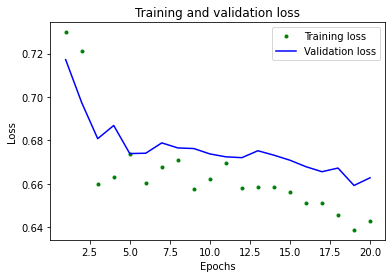

In [9]:
# Fit the model
EPOCHS = 20
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Get a list of all convolutional layers from the trained CNN model

def get_conv_layer_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # Get the layer input and output
        inputs = model.inputs
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list

In [11]:
# Define the custom layers

# Maximum layer
@tf.keras.utils.register_keras_serializable()
class MaxLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_max(inputs, axis=(1,2))
    
# Minimum layer
@tf.keras.utils.register_keras_serializable()
class MinLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_min(inputs, axis=(1,2))

# Mean layer
@tf.keras.utils.register_keras_serializable()
class MeanLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_mean(inputs, axis=(1,2))
    
# Sum Layer
@tf.keras.utils.register_keras_serializable()
class SumLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_sum(inputs, axis=(1,2))
    
# Variance Layer
@tf.keras.utils.register_keras_serializable()
class VarianceLayer(tf.keras.layers.Layer):
    
    def call(self, inputs):
        
        return tf.math.reduce_variance(inputs, axis=(1,2))

In [12]:

def build_feature_extraction_model(model, conv_layer_list):

    # Build the model
    inputs = tf.keras.Input(shape=(32, 32, 1))
    
    # Define the layers of the model
    # max_layer_im = MaxLayer()
    # min_layer_im = MinLayer()
    # mean_layer_im = MeanLayer()
    # sum_layer_im = SumLayer()
    # var_layer_im = VarianceLayer()
    
    concat_layer_im = tf.keras.layers.Concatenate(axis=-1)
    
    max_layer_list = []
    min_layer_list = []
    mean_layer_list = []
    sum_layer_list = []
    # var_layer_list = []
    concat_layer_list = []
    for i in range(len(conv_layer_list)):
        # max_layer_list.append(MaxLayer())
        # min_layer_list.append(MinLayer())
        # mean_layer_list.append(MeanLayer())
        # sum_layer_list.append(SumLayer())
        # var_layer_list.append(VarianceLayer())
        concat_layer_list.append(tf.keras.layers.Concatenate(axis=-1))
    
    total_concat_layer = tf.keras.layers.Concatenate(axis=-1)
    outputs_list = []
    
    # Calculate the values on the image itself
    # max_im = max_layer_im(inputs)
    # min_im = min_layer_im(inputs)
    # mean_im = mean_layer_im(inputs)
    # sum_im = sum_layer_im(inputs)
    max_im = tf.reduce_max(inputs, axis=(1,2))
    min_im = tf.reduce_min(inputs, axis=(1,2))
    mean_im = tf.reduce_mean(inputs, axis=(1,2))
    sum_im = tf.reduce_sum(inputs, axis=(1,2))
    # var_im = var_layer_im(inputs)
    # concat_im = concat_layer_im([max_im, min_im, mean_im, sum_im, var_im])
    concat_im = concat_layer_im([max_im, min_im, mean_im, sum_im])
    outputs_list.append(concat_im)
    
    
    # Iterate over all convolutional layers
    for i, conv_layer in enumerate(conv_layer_list):
        conv_layer_output = conv_layer_list[i](inputs)
        # max_fm = max_layer_list[i](conv_layer_output)
        # min_fm = min_layer_list[i](conv_layer_output)
        # mean_fm = mean_layer_list[i](conv_layer_output)
        # sum_fm = sum_layer_list[i](conv_layer_output)
        max_fm = tf.reduce_max(conv_layer_output, axis=(1,2))
        min_fm = tf.reduce_min(conv_layer_output, axis=(1,2))
        mean_fm = tf.reduce_mean(conv_layer_output, axis=(1,2))
        sum_fm = tf.reduce_sum(conv_layer_output, axis=(1,2))
        # var_fm = var_layer_list[i](conv_layer_output)
        # concat = concat_layer_list[i]([max_fm, min_fm, mean_fm, sum_fm, var_fm])
        concat = concat_layer_list[i]([max_fm, min_fm, mean_fm, sum_fm])
        outputs_list.append(concat)
        
    total_concat = total_concat_layer(outputs_list)

    model = tf.keras.Model(name="whole_model", inputs=inputs, outputs=total_concat)
    
    return model

# Get the convolutional layers
conv_layer_list = get_conv_layer_list(model)

feature_extractor = build_feature_extraction_model(model, conv_layer_list)
feature_extractor.build(input_shape=(None, 32, 32, 1))
feature_extractor.summary()

Model: "whole_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Functional)             (None, 16, 16, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Functional)           (None, 8, 8, 16)     1248        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Functional)           (None, 4, 4, 32)     5888        input_2[0][0]                    
________________________________________________________________________________________

In [13]:
# Save the model as tf lite model

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(feature_extractor) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('feature_extractor.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model as onnx model
tf2onnx.convert.from_keras(feature_extractor, output_path="feature_extractor.onnx")


# Save as keras model
feature_extractor.save("feature_extractor.h5")

print("Models saved.")

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmplsquyemb\assets
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Models saved.


In [14]:
layer_list = get_conv_layer_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"feature_extractor_conv_{i}.h5")

[<keras.engine.functional.Functional object at 0x000001DF5A20AD00>, <keras.engine.functional.Functional object at 0x000001DF6285A190>, <keras.engine.functional.Functional object at 0x000001DF628A0AC0>]


In [15]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_var = np.var(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_var,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_var = np.var(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_var,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 342)
[[1.37223633e+01 1.36000000e+01 1.99509559e+00 1.93000000e+01
  9.80000000e+00 1.40517000e+04 1.77978337e-01 0.00000000e+00
  5.76432049e-03 6.94202125e-01 6.30605221e-01 4.86933899e+00
  1.18613198e-01 8.08938891e-02 6.99649602e-02 0.00000000e+00
  0.00000000e+00 7.47433424e-01 6.50830209e-01 4.47000313e+00
  0.00000000e+00 0.00000000e+00 6.05486855e-02 0.00000000e+00
  8.47298373e-03 1.92993149e-01 1.99583858e-01 1.50929475e+00
  2.18590781e-01 1.07103691e-01 1.36384726e+00 0.00000000e+00
  1.47566605e+00 2.40443516e+00 2.79865074e+00 9.55471134e+00
  2.40245795e+00 1.80188668e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.18997574e+00
  0.00000000e+00 0.00000000e+00 4.55624542e+01 0.00000000e+00
  1.47566605e+00 1.77715744e+02 1.61434937e+02 1.24655078e+03
  3.03649788e+01 2.07088356e+01 7.63748167e-03 0.00000000e+00
  1.20597959e+00 0.00000000e+00 1.88440844e-01 0.00000000e+00
  5.84323704e-01 1.79971993e+00 8.30058753e-01 0.00000000e+

### Prepare Data for GBT

In [16]:
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_extractor.predict(X)], axis=1))

In [17]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,226,227,228,229,230,231,232,233,234,235
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,19.299999,9.8,...,2.77834,1.32025,0.070251,0.449991,0.203555,0.169846,0.099965,2.563022,0.27958,4.773179
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,20.200001,9.8,...,3.709987,0.98978,0.045079,0.128651,0.020267,0.12969,0.217348,2.456362,0.209813,4.709538


In [18]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 228)


In [19]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 228)
(180,)
(20, 228)
(20,)
[0]


### Simple GBT Classifier

Accuracy Score: 0.75


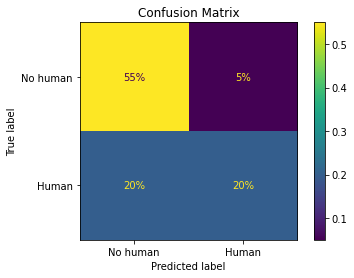

In [20]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
acc = clf.score(X_test_clf, y_test_clf)
print(f"Accuracy Score: {acc}")

# Calculate and display the confusion matrix
y_pred = clf.predict(X_test_clf)
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()

In [21]:
# Get the model size in kiB
def get_memory_size(clf, layer_list, fname = "clf_binary"):
    joblib.dump(clf, fname)
    model_size = os.path.getsize(fname)
    model_size = model_size / 1024
    print(f"GBT size in kiB: {model_size}")

    # Get the conv layers size in kiB
    layer_size = 0
    for i in range(len(layer_list)):
        layer_size = os.path.getsize(f"feature_extractor_conv_{i}.h5")
    layer_size = layer_size / 1024
    print(f"Conv layer size in kiB: {layer_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB: {layer_size + model_size}")
    
get_memory_size(clf, layer_list)

GBT size in kiB: 337.9111328125
Conv layer size in kiB: 40.1953125
Total size in kiB: 378.1064453125


### HP-Tuning for GBT 

In [22]:
# HP-Tuning
MAX_FEATURES = 150

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 100)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 4)
    max_features = hp.Int("max_features", 1, MAX_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)


In [23]:
MAX_TRIALS = 10

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning_binary')



tuner.search(X_train_clf, y_train_clf)

best_clf = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_clf.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_clf.get_params()}")

INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_binary\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_binary\oracle.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_binary\tuner0.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_binary\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Best model test score: 0.6
Best model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.5812338714385317, 'loss': 'deviance', 'max_depth': 3, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 45, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}


In [24]:
get_memory_size(best_clf, layer_list, fname="best_binary")

GBT size in kiB: 75.26953125
Conv layer size in kiB: 40.1953125
Total size in kiB: 115.46484375


Ground Truth: [1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0]
Prediction:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


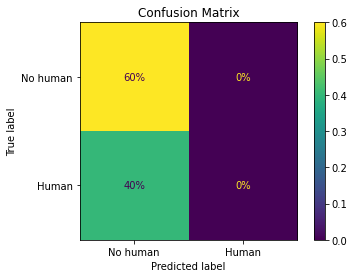

In [25]:
# Compare predictions and ground truth on testing set

y_pred = best_clf.predict(X_test_clf)


print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {y_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
plt.show()



In [30]:
# Convert model to onnx-format and save it
initial_type = [('float_input', FloatTensorType([None, 4]))]
onnx = convert_sklearn(best_clf, initial_types=initial_type)
with open("best_clf.onnx", "wb") as f:
    f.write(onnx.SerializeToString())




C:\Users\Felix\.conda\envs\ias0360-final-project\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Multilabel Classification

In [87]:
df.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


In [88]:
# Convert labels
label_converter = { 
    'Human': 0,
    'Several humans': 1, 
    'Non-human heat': 2, 
    'Ambigous heat': 3,
    'No heat':  4
}

df['label'] = df['label'].apply(lambda x: label_converter[x])
df.head(n=100)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,0
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,0
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,3
3030,3030,2021-05-07 13:10:30,3078,22.400000,-73,"[[10.9, 11.1, 11.2, 10.8, 12.0, 12.2, 12.7, 12...",True,1
1427,1427,2021-05-07 13:07:54,3078,21.799999,-82,"[[10.8, 10.9, 10.7, 10.7, 11.7, 11.4, 11.2, 10...",True,2
...,...,...,...,...,...,...,...,...
9911,9911,2021-05-07 13:13:12,C088,23.100000,-72,"[[10.6, 10.9, 12.0, 12.3, 13.5, 12.4, 12.8, 12...",True,2
4612,4612,2021-05-07 13:13:06,3078,23.100000,-78,"[[10.7, 12.1, 12.1, 11.4, 11.6, 11.3, 12.3, 12...",True,2
5300,5300,2021-05-07 13:06:01,C088,21.200001,-66,"[[11.5, 13.0, 12.4, 12.1, 13.0, 13.1, 12.6, 12...",True,3
5603,5603,2021-05-07 13:06:30,C088,21.299999,-63,"[[12.0, 11.8, 12.6, 12.6, 13.3, 12.9, 13.6, 13...",True,3


In [96]:
# Prepare the data
y = df['label'].to_numpy()
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(y)+1))
y_onehot = label_binarizer.transform(y)

X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y_onehot.shape)
print(y_onehot[:1])
assert np.all(np.sum(y_onehot, axis=1) == 1)
print(X.shape)

(200, 5)
[[1 0 0 0 0]]
(200, 32, 32, 1)


In [97]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

(180, 32, 32, 1)
(180, 5)
(15, 32, 32, 1)
(15, 5)
[[0 0 0 0 1]]


In [98]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [100]:
model.compile(
optimizer='adam',
loss= 'categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 5))
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 165 

Epoch 1/30
12/12 [==============================] - 1s 29ms/step - loss: 2.4561 - accuracy: 0.3333 - val_loss: 1.4148 - val_accuracy: 0.3333
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 1.5652 - accuracy: 0.3833 - val_loss: 1.2626 - val_accuracy: 0.3333
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 1.5315 - accuracy: 0.3389 - val_loss: 1.3155 - val_accuracy: 0.3333
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 1.4622 - accuracy: 0.3500 - val_loss: 1.2817 - val_accuracy: 0.3333
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4646 - accuracy: 0.3333 - val_loss: 1.3398 - val_accuracy: 0.3333
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4442 - accuracy: 0.3833 - val_loss: 1.3104 - val_accuracy: 0.3333
Epoch 7/30
12/12 [==============================] - 0s 10ms/step - loss: 1.4452 - accuracy: 0.4000 - val_loss: 1.3342 - val_accuracy: 0.3333
Epoch 8/30
12

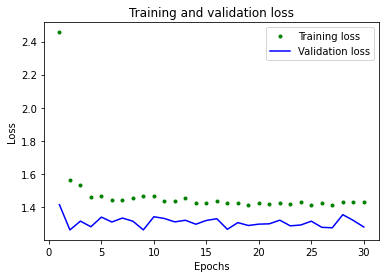

In [101]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [102]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

1 conv2d_4 (None, 32, 32, 32)
INFO:tensorflow:Assets written to: layer_0\assets


In [103]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_std = np.std(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_std,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 198)
[[1.37223633e+01 1.36000000e+01 1.41247853e+00 1.93000000e+01
  9.80000000e+00 1.40517000e+04 7.15011656e-01 0.00000000e+00
  0.00000000e+00 1.49491891e-01 8.17718327e-01 0.00000000e+00
  4.40455824e-01 0.00000000e+00 1.00603444e-03 1.66070892e-03
  3.48639518e-01 6.61285102e-01 2.87988130e-02 0.00000000e+00
  1.18140161e+00 2.82847486e-03 5.15798405e-02 7.84609318e-01
  9.37332064e-02 2.28866818e-03 7.34356642e-02 0.00000000e+00
  7.14292973e-02 4.15567163e-04 0.00000000e+00 5.53556625e-03
  4.53765281e-02 9.10370886e-01 0.00000000e+00 1.90507658e-02
  0.00000000e+00 8.52914825e-02 5.91847599e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.27529311e-01 0.00000000e+00
  4.57392097e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.88592100e-01 6.38815343e-01 0.00000000e+00 0.00000000e+00
  1.16766357e+00 0.00000000e+00 0.00000000e+00 7.49710917e-01
  2.33299397e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+

In [104]:
df_train_expanded = pd.DataFrame(np.concatenate([df.head(X.shape[0]), feature_map_means], axis=1))

In [105]:
# Prepare the data for gradient boosting
y_clf = df_train_expanded[7].to_numpy().astype(int)
X_clf= df_train_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 198)


In [107]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 198)
(180,)
(20, 198)
(20,)
[4]


In [108]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)# Train the GBT

0.4

In [109]:
# HP-Tuning
NUM_FEATURES = 198

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 300)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 8)
    max_features = hp.Int("max_features", 1, NUM_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)

In [110]:
MAX_TRIALS = 40

# TODO: Use maybe other metrices!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score, balanced_accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning')



tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_model.get_params()}")

Trial 41 Complete [00h 00m 15s]
score: 0.2891082251082251

Best score So Far: 0.3476017316017316
Total elapsed time: 00h 10m 55s
INFO:tensorflow:Oracle triggered exit
Best model test score: 0.35
Best model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.6356198890804754, 'loss': 'deviance', 'max_depth': 2, 'max_features': 144, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 203, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}


In [111]:
get_memory_size(best_model, layer_list, fname="best")

GBT size in kiB: 930.3837890625
Conv layer size in kiB: 4.0
Total size in kiB: 934.3837890625


In [112]:
# Compare predictions and ground truth
pred = best_model.predict(X_test_clf)

print(f"Ground Truth: {y_test_clf}")
print(f"Prediction:   {pred}")

Ground Truth: [0 2 3 3 0 0 2 3 0 2 2 3 2 0 2 0 0 2 0 3]
Prediction:   [2 0 2 2 3 0 2 2 0 0 2 2 2 0 2 2 2 0 2 0]
